In [56]:
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl

from numba import njit

from joblib import Parallel, delayed

import agama
agama.setUnits(mass=1E10, length=1, velocity=1)

from scipy.interpolate import interp1d

In [15]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'
name = 'MW3_MHG0.25_GSE2'
lvl = 'lvl4'


In [16]:
COM_fpath = basepath + 'anlys/COM/COM_' + name+'-'+lvl + '.npy'
COM_file = np.load(COM_fpath, allow_pickle=True).item()

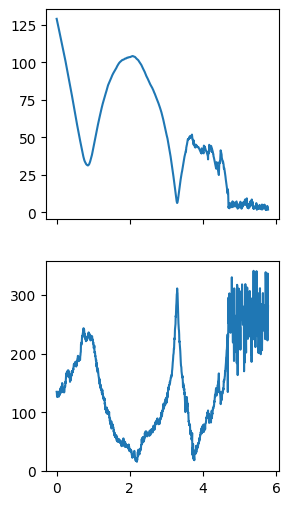

In [57]:
# plot orbit

COM = COM_file['GSE_COM'] - COM_file['MW_COM']
COMV = COM_file['GSE_COMV'] - COM_file['MW_COMV']

t = COM_file['Time']
r = np.linalg.norm(COM, axis=1)
v = np.linalg.norm(COMV, axis=1)

fig, ax = plt.subplots(2, 1, figsize=(3, 6), sharex=True)
ax[0].plot(t, r)
ax[1].plot(t, v)

In [68]:
print('pericenter r [kpc]:', np.min(r[t<2]))

pericenter r [kpc]: 31.24948594350366


In [17]:
ics = arepo.Snapshot(basepath + 'ics/'+name+'/'+lvl+'/GSE_ICs.dat')

In [18]:
pos_halo = ics.part1.pos
mass_halo = np.full(ics.NumPart_Total[1], ics.MassTable[1])

pos_bar = np.concatenate((ics.part0.pos, ics.part2.pos))
mass0 = np.full(ics.NumPart_Total[0], ics.MassTable[0])
mass2 = np.full(ics.NumPart_Total[2], ics.MassTable[2])
mass_bar = np.concatenate((mass0, mass2))

In [19]:
pot_halo = agama.Potential(type="Multipole", particles=(pos_halo, mass_halo),
                           symmetry='a', gridsizeR=20, lmax=2)

pot_bar  = agama.Potential(type="CylSpline", particles=(pos_bar, mass_bar), 
                          symmetry='a', gridsizer=20, gridsizez=20,
                          mmax=0, Rmin=0.2, Rmax=50, Zmin=0.02, Zmax=10)

pot = agama.Potential(pot_halo, pot_bar)

In [21]:
def get_surf_dens(ics, Rmax=10):
    
    R = np.linalg.norm(ics.part0.pos[:,:2], axis=1)
    
    Rmin = 0
    dR = 0.5
    
    aveR = []
    surf = []
    
    while Rmin < Rmax:
        key = np.logical_and(R >= Rmin, R < Rmax)
        aveR.append(np.mean(R[key]))
        
        menc = ics.MassTable[0] * len(np.where(key)[0])
        area = np.pi * ((Rmin+dR)**2 - Rmin**2)
        
        surf.append(menc/area)
        Rmin += dR
    
    return np.array(aveR), np.array(surf)
    

In [30]:
def get_max_force(R, pot):
    zlist = np.linspace(0, 20, 1000)
    R = np.full(len(zlist), R)
    points = np.column_stack((R, zlist*0, zlist))
    force, deriv = pot.forceDeriv(points)
    
    return zlist[np.argmax(np.abs(force[:,2]))], np.max(np.abs(force[:,2]))
    

In [40]:
ics_MW = arepo.Snapshot(basepath + 'ics/'+name+'/'+lvl+'/MW_ICs.dat')

In [51]:
def get_CGM_dens(ics, rmax=120):
    center = np.array([300, 300, 300])
    r = np.linalg.norm(ics.part0.pos, axis=1)
    
    rmin = 0
    dr = 0.5
    
    aver = []
    rho = []
    
    while rmin < rmax:
        key = np.logical_and(r >= rmin, r < rmin + dr)
        aver.append(np.mean(r[key]))
        
        menc = np.sum(ics.part0.mass[key])
        vol = (4*np.pi/3) * ((rmin + dr)**3 - rmin**3)
        rho.append(menc/vol)
        
        rmin += dr
    
    return np.array(aver), np.array(rho)
    

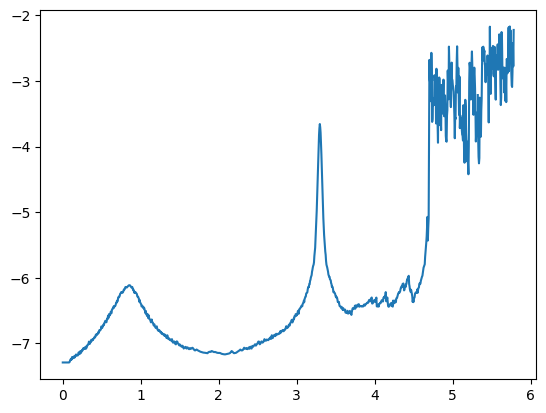

In [63]:
aver, rho = get_CGM_dens(ics_MW)
rho_interp = interp1d(aver, rho, bounds_error=False, fill_value = np.min(rho))

rho_inflight = rho_interp(r)
plt.plot(t, np.log10(rho_inflight))
max_rho = np.max(rho_inflight[t < 2])

In [55]:
aveR, surf = get_surf_dens(ics, Rmax=6)

maxFz = []
for R in aveR:
    _, maxFz_ = get_max_force(R, pot)
    maxFz.append(maxFz_)
maxFz = np.array(maxFz)

rho_needed = surf * maxFz / vmax**2

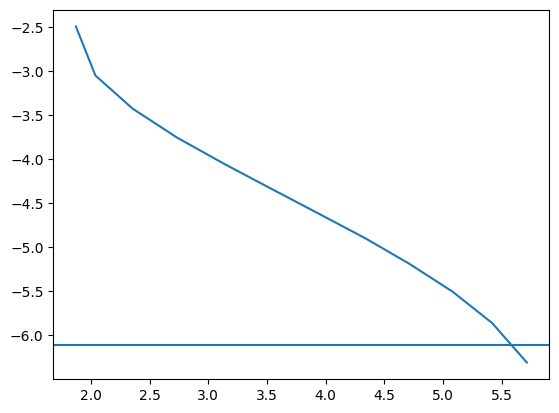

In [66]:
plt.plot(aveR, np.log10(rho_needed))
plt.axhline(np.log10(max_rho))